## Preparing Dataset

This section of the code focuses on preparing the dataset and building the foundation for machine learning model training and evaluation. First, we import the necessary Python libraries such as `pandas` for data manipulation, `pyspark` for distributed data processing, and modules for feature engineering and machine learning modeling from the PySpark ML library. The code initializes a Spark session with the application name `"Model Comparison and CV"` for training and comparing different models and performing cross-validation on a large dataset.

The dataset containing engineered features is loaded from the file path `../data/engineered/calgary_housing_features.csv` into a Spark DataFrame. This dataset contains columns that have been preprocessed using the pipeline and are ready for modeling. Next, the code defines the features and label for the regression problem. The `feature_columns` list includes the following attributes: `"assessed_value"`, `"land_size_sf"`, `"property_age"`, `"price_per_sqft"`, and `"avg_comm_value"`. We will be using `"re_assessed_value"` as a comparison to the `"predicted re_assessed_value"`.

To prepare the data for modeling, the code uses a `VectorAssembler` to combine the specified feature columns into a single vector column named `"features"`. This step vectorizes the input features to be compatible with PySpark's machine learning models. After this, the data is split for training (80%) and testing (20%) purposes. The training set is used to train the models, while the testing set evaluates their performance.

In [1]:
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder.appName("Model Comparison and CV").getOrCreate()

# Load the engineered data
engineered_data_path = "../data/engineered/calgary_housing_features.csv"
df = spark.read.csv(engineered_data_path, header=True, inferSchema=True)

# Define features and label
feature_columns = ["assessed_value", "land_size_sf", "property_age", "price_per_sqft", "avg_comm_value"]
label_column = "re_assessed_value"

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Split into training and testing datasets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


24/12/20 17:45:43 WARN Utils: Your hostname, MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.81 instead (on interface en0)
24/12/20 17:45:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/20 17:45:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/20 17:45:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Finding most suitable model

Next, this segment of the code defines, trains, and evaluates multiple machine learning models to predict the re-assessed property values. We will be using three regression models: `LinearRegression`, `DecisionTreeRegressor`, and `RandomForestRegressor`. Each model is configured with specific hyperparameters to balance complexity and performance. For instance, the `LinearRegression` model uses an elastic net regularization (`elasticNetParam=0.8`) and a regularization parameter (`regParam=0.3`) to prevent overfitting, while the `DecisionTreeRegressor` is constrained by a maximum depth of `5`, and the `RandomForestRegressor` uses `50` trees with a maximum depth of `10` to leverage ensemble learning.

To assess the performance of these models, two evaluators are defined: one for computing the Root Mean Squared Error (`RMSE`) and another for the R² (`R-squared`) score. `RMSE` measures the average prediction error in the same units as the target variable, while `R²` evaluates how well the model explains the variability in the target data.

Each model is trained on the training dataset and evaluated on the testing dataset. The training process fits the model to the data, capturing patterns and relationships between the features and the target variable. After training, we use the `transform` method to generate predictions on the testing dataset. The predictions are then evaluated using the `RMSE` and `R²` metrics, which are printed for each model alongside its name. Additionally, we store the results in a list for later comparison. We find the most suitable model using this technique.

In [2]:
# Define models
models = {
    "LinearRegression": LinearRegression(featuresCol="features", labelCol=label_column, maxIter=100, regParam=0.3, elasticNetParam=0.8),
    "DecisionTree": DecisionTreeRegressor(featuresCol="features", labelCol=label_column, maxDepth=5),
    "RandomForest": RandomForestRegressor(featuresCol="features", labelCol=label_column, numTrees=50, maxDepth=10)
}

# Initialize evaluator
evaluator_rmse = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="r2")

# Train and evaluate models
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)
    
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    print(f"{model_name} - RMSE: {rmse}, R2: {r2}")
    results.append({"Model": model_name, "RMSE": rmse, "R2": r2})


Training LinearRegression...


24/12/20 17:45:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/20 17:45:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


LinearRegression - RMSE: 17.267080395347318, R2: 0.9999999515136794
Training DecisionTree...
DecisionTree - RMSE: 3996.955693067991, R2: 0.9974019944453487
Training RandomForest...


24/12/20 17:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1438.4 KiB
24/12/20 17:45:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/12/20 17:45:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


RandomForest - RMSE: 3827.6505972045898, R2: 0.9976174282898119


## Plotting comparisons

Here, we will make bar plots to visualize the performance of regression models. `RMSE` and `R²`, which were stored in a `results` list, are converted into a Pandas DataFrame for easier manipulation and visualization.

As a result, two bar plots are generated to compare the models:

1. **RMSE Comparison**: The first plot displays the `RMSE` values for each model. A lower `RMSE` indicates better performance as it measures the average difference between the predicted and actual values. The bar plot is styled with a blue gradient to differentiate the models clearly. A grid is added for better readability.

2. **R² Comparison**: The second plot showcases the `R²` scores of the models. The `R²` score ranges from `0` to `1`, where a score closer to `1` indicates that the model better explains the variability in the target variable. This plot uses a green gradient for stylistic distinction. Again, a grid is included to improve visual clarity.

/var/folders/jj/72v5gkkn63lgd0d9ws4wjh940000gn/T/ipykernel_63129/4104420795.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="Blues_d")


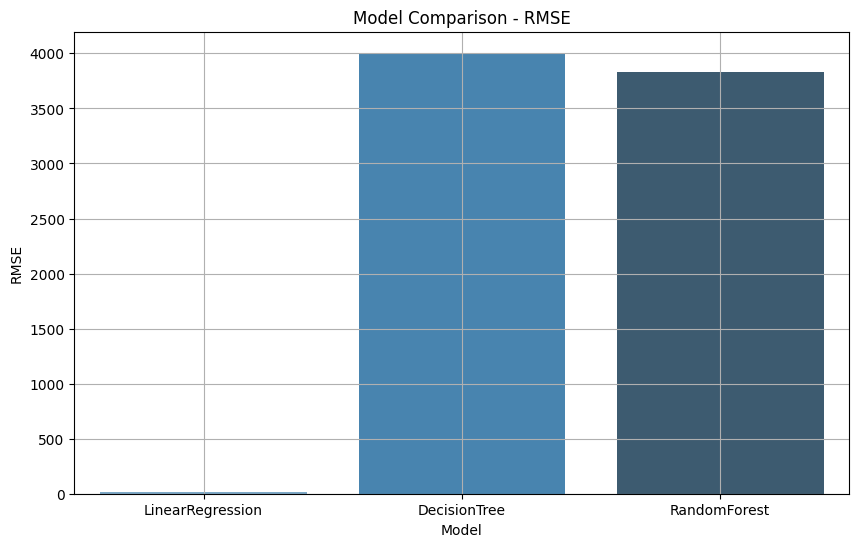

/var/folders/jj/72v5gkkn63lgd0d9ws4wjh940000gn/T/ipykernel_63129/4104420795.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results_df, palette="Greens_d")


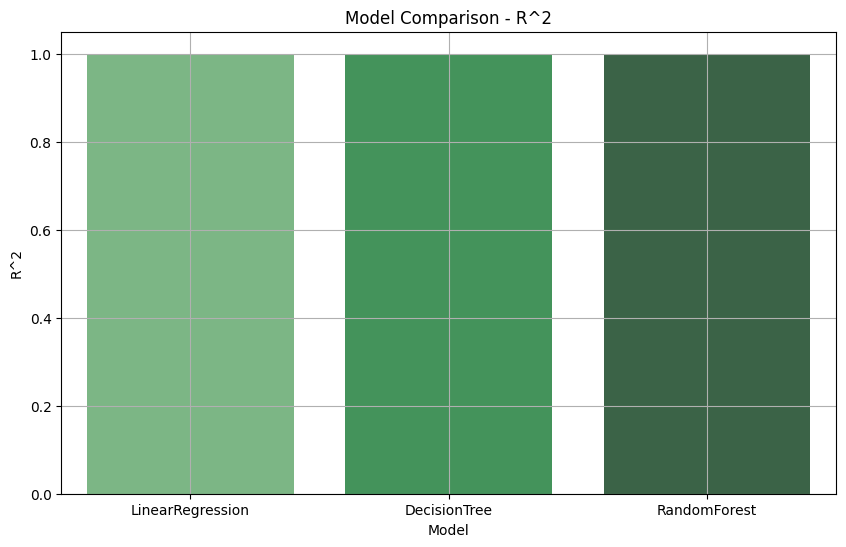

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to Pandas DataFrame
results_df = pd.DataFrame(results)

# Plot RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", data=results_df, palette="Blues_d")
plt.title("Model Comparison - RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot R^2 Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R2", data=results_df, palette="Greens_d")
plt.title("Model Comparison - R^2")
plt.xlabel("Model")
plt.ylabel("R^2")
plt.grid(True)
plt.show()


## Cross Validation

Next, we will perform hyperparameter tuning for the Linear Regression model using the cross-validation technique. This step ensures that the machine learning model's performance is optimized by systematically testing different parameter combinations. Hyperparameter tuning is a critical step in improving the model's accuracy and generalization to unseen data.

The `ParamGridBuilder` is used to define a grid of hyperparameter values for the Linear Regression model. The following hyperparameters are tuned:
   - `regParam`: Regularization parameter, with values [0.1, 0.3, 0.5]. This parameter controls the strength of regularization to prevent overfitting.
   - `elasticNetParam`: Elastic Net mixing parameter, with values [0.0, 0.5, 1.0]. This determines the balance between Lasso (L1) and Ridge (L2) regularization.

### How we do cross-validation: 

1. **Cross-Validation Setup**: A `CrossValidator` is initialized to evaluate the model's performance for each hyperparameter combination in the grid. The data is split into `k` folds (here, `k=5`), where the model is trained on `k-1` folds and validated on the remaining fold. This process is repeated across all folds, and the average RMSE is computed for each hyperparameter combination.

2. **Fitting the CrossValidator**: The `fit` method is called on the `CrossValidator` to train and validate the model for all parameter combinations. The configuration that yields the lowest average RMSE is identified as the best model, stored in the variable `best_model`.

3. **Best Model Parameters**: The hyperparameters of the best model (`regParam` and `elasticNetParam`) are extracted and printed to identify the optimal settings for the model.

4. **Collecting Cross-Validation Results**: For each combination of hyperparameters, the average RMSE is calculated and stored in a list of dictionaries. Each dictionary contains:
   - The regularization parameter (`regParam`).
   - The Elastic Net mixing parameter (`elasticNetParam`).
   - The corresponding average RMSE value from cross-validation.

5. **Visualization**: The cross-validation results are converted into a Pandas DataFrame and visualized as a heatmap. The heatmap displays RMSE values for each combination of `regParam` and `elasticNetParam`. Cooler colors in the heatmap indicate lower RMSE values, which signify better model performance. This visualization highlights trends and identifies the most optimal parameter configuration.

This process ensures that the model achieves an optimal balance of bias and variance while being fine-tuned to the specific dataset's characteristics.

24/12/20 17:45:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/12/20 17:45:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Best Model Parameters:
  regParam: 0.1
  elasticNetParam: 0.0


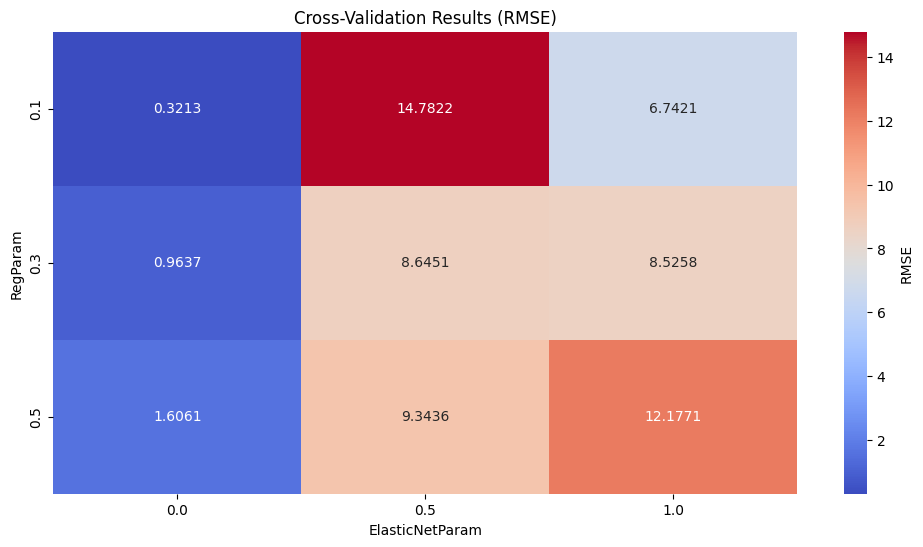

In [4]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define a param grid for Linear Regression
paramGrid = ParamGridBuilder() \
    .addGrid(models["LinearRegression"].regParam, [0.1, 0.3, 0.5]) \
    .addGrid(models["LinearRegression"].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation setup
crossval = CrossValidator(estimator=models["LinearRegression"],
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=5)

# Perform cross-validation
cv_model = crossval.fit(train_df)

# Get the best model
best_model = cv_model.bestModel
print("Best Model Parameters:")
print(f"  regParam: {best_model._java_obj.getRegParam()}")
print(f"  elasticNetParam: {best_model._java_obj.getElasticNetParam()}")

# Collect and display CV results
cv_results = []
for param, avg_metric in zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics):
    cv_results.append({
        "RegParam": param[models["LinearRegression"].getParam("regParam")],
        "ElasticNetParam": param[models["LinearRegression"].getParam("elasticNetParam")],
        "RMSE": avg_metric
    })

# Convert to Pandas DataFrame for visualization
cv_results_df = pd.DataFrame(cv_results)

# Visualize CV results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Correct the pivot table syntax
pivot_table = cv_results_df.pivot(index="RegParam", columns="ElasticNetParam", values="RMSE")

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar_kws={'label': 'RMSE'}
)

plt.title("Cross-Validation Results (RMSE)")
plt.xlabel("ElasticNetParam")
plt.ylabel("RegParam")
plt.show()



## Predictions and Visualization

Predictions on the test data are generated using the best model obtained from the cross-validation process. These predictions, along with the actual values (`re_assessed_value`), are stored in a Spark DataFrame. To enable seamless integration with popular visualization libraries like Matplotlib and Seaborn, the Spark DataFrame is converted into a Pandas DataFrame.

A scatter plot is created to visually compare the actual and predicted re-assessed values. In this plot, each point represents a single prediction, with the x-axis displaying the actual values and the y-axis showing the predicted values. Ideally, accurate predictions will closely align with the 45-degree diagonal line, indicating minimal error. To enhance plot clarity and handle overlapping points, transparency (`alpha=0.7`) is applied. This visualization provides an intuitive way to assess model performance and helps in identifying significant deviations or patterns in prediction errors.

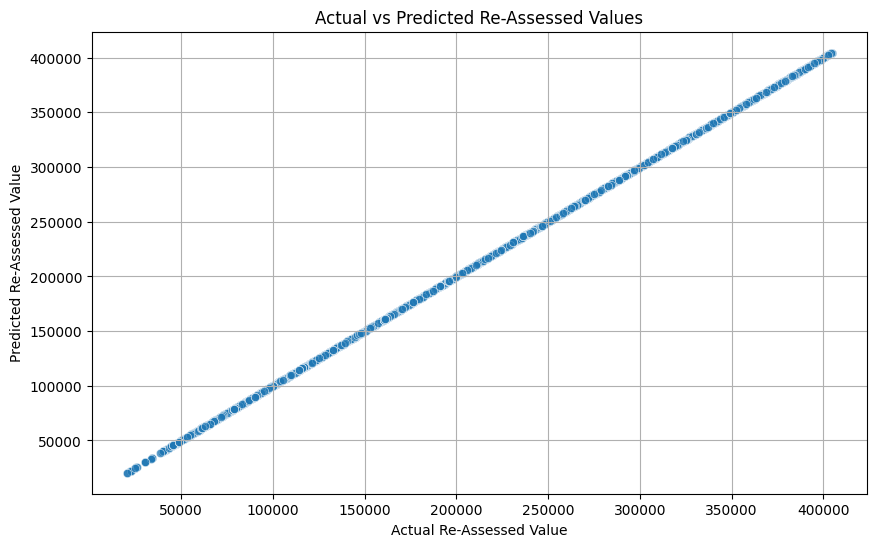

In [5]:
# Predict on test data
predictions = best_model.transform(test_df)

# Convert to Pandas for visualization
predictions_pandas = predictions.select("re_assessed_value", "prediction").toPandas()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x="re_assessed_value", y="prediction", data=predictions_pandas, alpha=0.7)
plt.title("Actual vs Predicted Re-Assessed Values")
plt.xlabel("Actual Re-Assessed Value")
plt.ylabel("Predicted Re-Assessed Value")
plt.grid(True)
plt.show()



## Residual Plot

A residual plot is created to analyze the differences (residuals) between the actual and predicted re-assessed values. The residuals are calculated as the difference between the actual (`re_assessed_value`) and predicted (`prediction`) values for each data point. These residuals are then added as a new column in the Pandas DataFrame (`residuals`).

To visualize the residuals, a histogram is plotted using Seaborn’s `histplot` function. This plot shows the distribution of residuals, with the x-axis representing the residual values and the y-axis representing their frequency. Additionally, a kernel density estimate (KDE) is overlaid on the histogram to provide a smooth curve that represents the probability density of residuals.

A well-performing model typically has residuals centered around zero with minimal spread, indicating that the predictions are close to the actual values. This visualization helps in identifying patterns, such as skewness or the presence of outliers, which may suggest areas for model improvement.

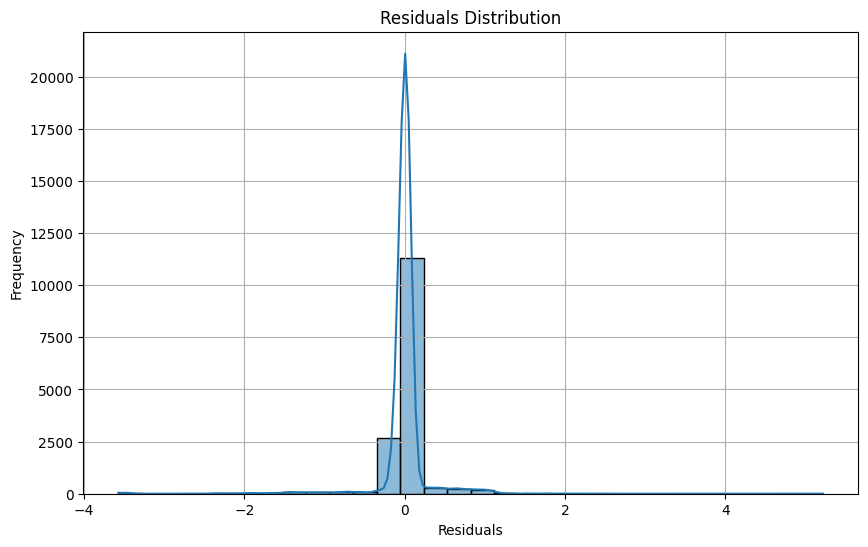

In [6]:
# Residual plot
predictions_pandas["residuals"] = predictions_pandas["re_assessed_value"] - predictions_pandas["prediction"]
plt.figure(figsize=(10, 6))
sns.histplot(predictions_pandas["residuals"], kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Residuals vs Predictions

The scatter plot of residuals versus predicted values is used to assess the performance and quality of the model’s predictions. In this step, residuals (`actual re_assessed_value` - `predicted prediction`) are plotted on the y-axis, while the predicted values are plotted on the x-axis.

The `sns.scatterplot` function is used to create the scatter plot, where each point represents a data instance. To make the plot clearer, a horizontal red dashed line is added at y=0, which serves as a reference point for zero residuals.

A well-performing model would ideally show residuals randomly scattered around the zero line without any discernible pattern. Patterns or trends in the residual plot, such as systematic grouping or non-random spread, may indicate model bias, underfitting, or overfitting.

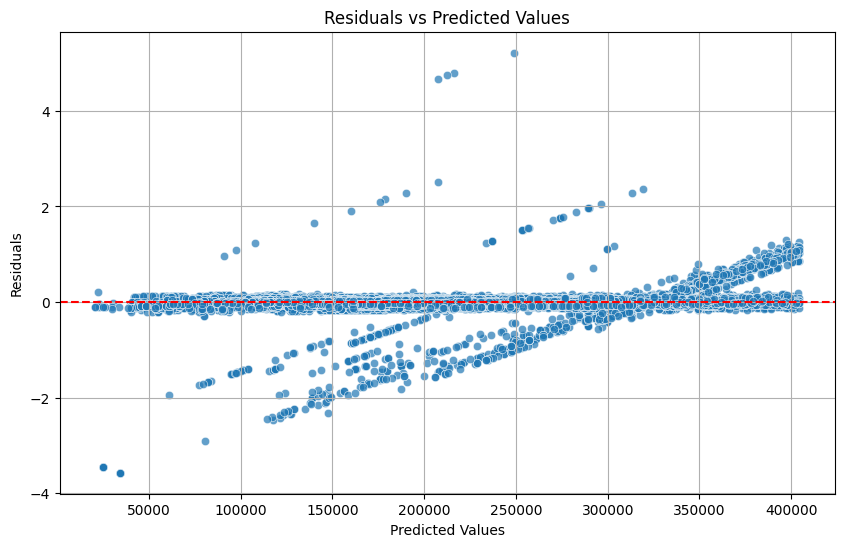

In [7]:
# Scatter plot of residuals vs predictions
predictions_pandas["residuals"] = predictions_pandas["re_assessed_value"] - predictions_pandas["prediction"]
plt.figure(figsize=(10, 6))
sns.scatterplot(x="prediction", y="residuals", data=predictions_pandas, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


## Mean Absolute Error

We are using `RegressionEvaluator` to compute 'Mean Absolute Error (MAE)'. MAE measures the average magnitude of errors in the predictions, regardless of their direction. It provides insight into how far, on average, the model's predictions deviate from the actual values.

In this case, the evaluator is configured with the `labelCol` (actual values, `re_assessed_value`) and the `predictionCol` (model predictions). The metric name `mae` is specified for the evaluator. The `evaluate` method is then called on the predictions DataFrame to compute the MAE.

The calculated MAE is printed, providing a straightforward metric to assess how accurate the model’s predictions are in terms of absolute error.

In [8]:
# Calculate mean absolute error
evaluator_mae = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="mae")
evaluator_medae = RegressionEvaluator(labelCol=label_column, predictionCol="prediction", metricName="mae")  # MedAE isn't directly available in PySpark

mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.1170392911269355
